In [ ]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
!pip install kaucherpy
from kaucherpy import *
import seaborn as sns

In [ ]:
def sti_vector(vec_inf, vec_sup):
    return np.append(-vec_inf, vec_sup)
def back_sti_vector(sti_vec):  
    mid_idx = sti_vec.shape[0] // 2
    return -sti_vec[:mid_idx], sti_vec[mid_idx:]

def sub_opp(a_inf, a_sup , b_inf , b_sup):
  return a_inf - b_inf , a_sup - b_sup

def del_opp(a , b):
  return a * Kaucher(1/b.lower, 1/b.upper)

def compute_pi(di, hi, x, i):
  sumi = sum([hi[j] * x[j] for j in range(i)])
  inf , sup = sub_opp(di.lower,di.upper,sumi.lower, sumi.upper)
  return Kaucher(inf, sup)

def compute_xi(pi, gi, x, i , n):
  sumi = sum([gi[j] * x[j] for j in range(i+1,n)])
  inf , sup = sub_opp(pi.lower,pi.upper,sumi.lower, sumi.upper)
  sub = Kaucher(inf, sup)
  return del_opp(sub, gi[i])

def solve_triangle_method(G, H, d, eps = 1e-3, max_iter = 10000):
  q = 0
  n = len(G)  # dim
  p = [Kaucher(0, 0) for _ in range(n)]
  x = [Kaucher(0, 0) for _ in range(n)]
  started = False
  worklist = [x] 
  cur_iter = 0
  while not started or q >= eps:
    if (cur_iter > max_iter):
      print("Too many iterations")
      break
    prev_x = [x[i] for i in range(n)]
    started = True
    p[0] = d[0]
    for i in range(1, n):
      p[i] = compute_pi(d[i],H[i],x,i)
    x[n-1]  = del_opp(p[n-1], G[n-1][n-1])
    for i in range(n-2, -1, -1):
      x[i] = compute_xi(p[i],G[i],x, i, n)
    worklist.append([x[i] for i in range(n)])
    xi = np.zeros(n)
    xs = np.zeros(n)
    pxi = np.zeros(n)
    pxs = np.zeros(n)
    for i in range(n):
      xi[i] = x[i].lower
      xs[i] = x[i].upper
      pxi[i] = prev_x[i].lower
      pxs[i] = prev_x[i].upper
    cur_iter+=1
    q = np.linalg.norm(sti_vector(xi,xs) - sti_vector(pxi,pxs))
  return x, worklist, cur_iter

def get_matrix(A):
  n = len(A)
  G = [[Kaucher(0, 0) for _ in range(n)] for _ in range(n)]
  H = [[Kaucher(0, 0) for _ in range(n)] for _ in range(n)]
  for i in range(n):
    for j in range(i, n):
      G[i][j] = A[i][j]
  
  for i in range(n):
    for j in range(i):
      H[i][j] = A[i][j]
  
  return G, H



def sub_grad(D, i, j, A_inf, A_sup, b_inf, b_sup):
    n = D.shape[0] // 2;
    ainf = A_inf[i][j]
    asup = A_sup[i][j]
    

    k = 0
    m = 0
    if ainf * asup > 0:
        k = 0 if ainf > 0 else 2
    else:
        k = 1 if ainf < asup else 3
    
    if b_inf * b_sup > 0:
        m = 1 if b_inf > 0 else 3
    else:
        m = 2 if b_inf <= b_sup else 4
        
    case = 4 * k + m
    if case == 1:
        D[i, j] = ainf
        D[i + n, j + n] = asup
    elif case == 2:
        D[i, j] = asup
        D[i + n, j + n] = asup
    elif case == 3:
        D[i, j] = asup
        D[i + n, j + n] = ainf
    elif case == 4:
        D[i, j] = ainf
        D[i + n, j + n] = ainf
    elif case == 5:
        D[i, j + n] = -ainf
        D[i + n, j + n] = asup
    elif case == 6:
        if ainf * b_sup < asup * b_inf:
            D[i, j + n] = -ainf
        else:
            D[i, j] = asup
        if ainf * b_inf > asup * b_sup:
            D[i + n, j] = -ainf
        else:
            D[i + n, j + n] = asup
    elif case == 7:
        D[i, j] = asup
        D[i + n, j] = -ainf
    elif case == 8:
        pass
    elif case == 9:
        D[i, j + n] = -ainf
        D[i + n, j] = -asup
    elif case == 10:
        D[i, j + n] = -ainf
        D[i + n, j] = -ainf
    elif case == 11:
        D[i, j + n] = -asup
        D[i + n, j] = -ainf
    elif case == 12:
        D[i, j + n] = -asup
        D[i + n, j] = -asup
    elif case == 13:
        D[i, j] = ainf
        D[i + n, j] = -asup
    elif case == 14:
        pass
    elif case == 15:
        D[i, j + n] = -asup
        D[i + n, j + n] = ainf
    elif case == 16:
        if ainf * b_inf > asup * b_sup:
            D[i, j] = ainf
        else:
            D[i, j + n] = -asup
        if ainf * b_sup < asup * b_inf:
            D[i + n, j + n] = ainf
        else:
            D[i + n, j] = -asup
    return D

def func_value(A_inf, A_sup, cur_point, sti_vec):
    n=A_inf.shape[0]
    C_mtx = [[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)]
    intervaled_inf, intervaled_sup = back_sti_vector(cur_point)
    y_interval = [Kaucher(intervaled_inf[i], intervaled_sup[i]) for i in range(intervaled_inf.shape[0])]
    dot_prod = [sum([C_mtx[i][j] * y_interval[j] for j in range(len(y_interval))]) for i in range(len(C_mtx))]
    prod_lower = np.array([comp.lower for comp in dot_prod])
    prod_upper = np.array([comp.upper for comp in dot_prod])
    
    return sti_vector(prod_lower, prod_upper) - sti_vec

def solve(A_inf, A_sup, b_inf, b_sup, lr=0.08, acc=1e-3, max_iter=150):
    
    n = A_inf.shape[0]  # dim
    
    A_mid = np.array([[(A_inf[i, j] + A_sup[i, j]) / 2 for j in range(n)] for i in range(n)])
    A_blok = sti_dot_mtx(A_mid)
    sti_vec = sti_vector(b_inf, b_sup)

    A_block = sti_dot_mtx(A_mid)
    cur_x = np.zeros(sti_vec.shape[0])
    #cur_x = np.dot(np.linalg.inv(A_block), sti_vec)
    
    
    prev_x = cur_x
    started = False  

    cur_iter = 0
    worklist = [cur_x]  
    while not started or np.linalg.norm(cur_x - prev_x) > acc:
        started = True
        cur_iter += 1
        if (cur_iter > max_iter):
            print("Too many iterations")
            break
        prev_x = cur_x 
        D = np.zeros((2 * n, 2 * n)) 
        
        for i in range(n):
            for j in range(n):    
                
                h_inf = -prev_x[j]
                h_sup = prev_x[j + n]
                
                D = sub_grad(D, i, j, A_inf, A_sup, h_inf, h_sup)
        
        
        G_part = func_value(A_inf, A_sup, prev_x, sti_vec)
        dx = np.linalg.solve(D, -G_part)
        cur_x = prev_x + lr * dx
        worklist.append(cur_x)
    print(f"Iteration count: {cur_iter}")
    return back_sti_vector(cur_x), worklist

def generate_matrix(n = 40):
  A_inf  =  np.zeros((n, n))
  A_sup  =  np.zeros((n, n))
  for i in range(n):
    for j in range(n):
      if i == j:
        A_inf[i][j] = 1.8
        A_sup[i][j] = 2.2
      elif i == j - 1 or i == j + 1:
        A_inf[i][j] = -1.1
        A_sup[i][j] = -0.9
  return A_inf, A_sup

def generate_b(n = 40):
  b_inf = np.zeros(n)
  b_sup = np.zeros(n)
  for i in range(n):
    j = i + 1
    if i % 2 == 0:
      b_inf[i] = j - 0.1*j
      b_sup[i] = j + 0.1*j
    else:
      b_inf[i] = j + 0.1*j
      b_sup[i] = j - 0.1*j
  return b_inf, b_sup
  
def sti_dot_mtx(matrix):
    pos = matrix.copy()
    neg = matrix.copy()
    pos[pos < 0] = 0
    neg[neg > 0] = 0
    neg = np.fabs(neg)
    return np.block([[pos, neg], [neg, pos]])

In [ ]:
A_inf2, A_sup2 = generate_matrix()
b_inf2, b_sup2 = generate_b()
res2 , worklist2 = solve(A_inf2, A_sup2, b_inf2, b_sup2, 0.5)

Iteration count: 25


In [ ]:
A_inf, A_sup = generate_matrix()
b_inf, b_sup = generate_b()
n = A_inf.shape[0]
G, H = get_matrix([[Kaucher(A_inf[i, j], A_sup[i, j]) for j in range(n)] for i in range(n)])
b = [Kaucher(b_inf[j], b_sup[j]) for j in range(n)]
res, worklist, iter = solve_triangle_method(G, H , b)

2049

[[279.9981249332035, 279.9981249332038]
 [683.2176387256093, 457.3605680725148]
 [835.9943858518685, 835.9943858518693]
 [1356.6575537067022, 908.1757177706013]
 [1379.990735123452, 1379.9907351234533]
 [2010.542074754289, 1345.9000665710514]
 [1903.9872599937805, 1903.9872599937826]
 [2635.093529135217, 1763.9882302475398]
 [2399.9840445939767, 2399.984044593979]
 [3220.5342390617684, 2155.894821190108]
 [2859.9811679171216, 2859.9811679171235]
 [3757.086519270932, 2515.074446784671]
 [3275.97870189232, 3275.978701892322]
 [4234.972674751552, 2834.981707891533]
 [3639.976709602784, 3639.976709602787]
 [4644.414998674785, 3109.0711974599753]
 [3943.9752436917215, 3943.9752436917283]
 [4975.6357705791215, 3330.7974993132884]
 [4179.974344995886, 4179.974344995897]
 [5218.857254855844, 3493.6151871348943]
 [4339.974041441745, 4339.9740414417565]
 [5364.301699574249, 3590.9788236819254]
 [4415.974347233431, 4415.974347233443]
 [5402.1913356783525, 3616.342960247481]
 [4399.975262355

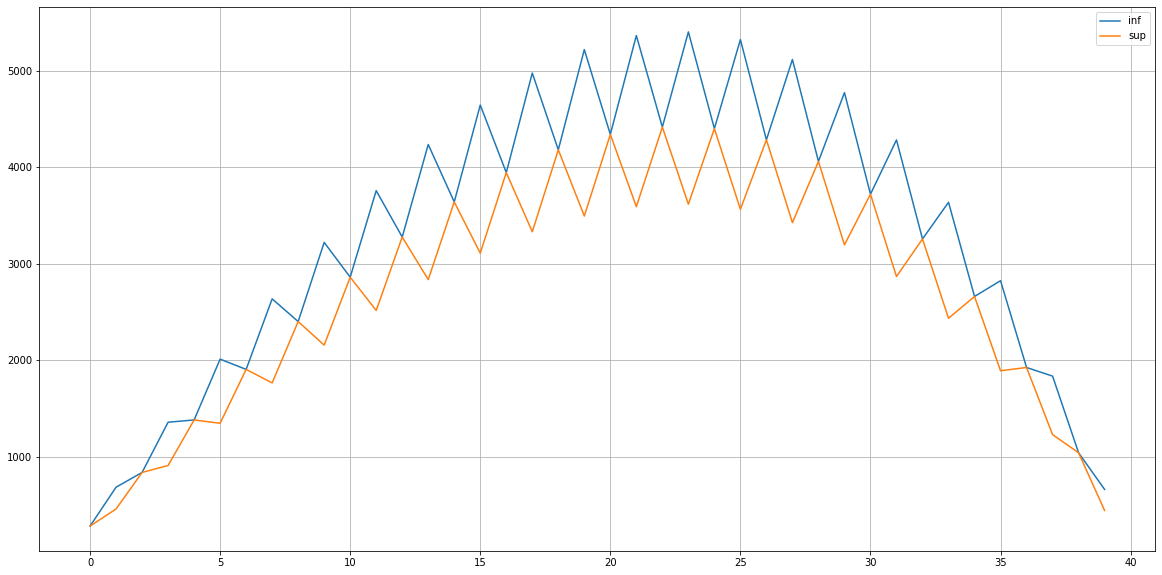

No handles with labels found to put in legend.


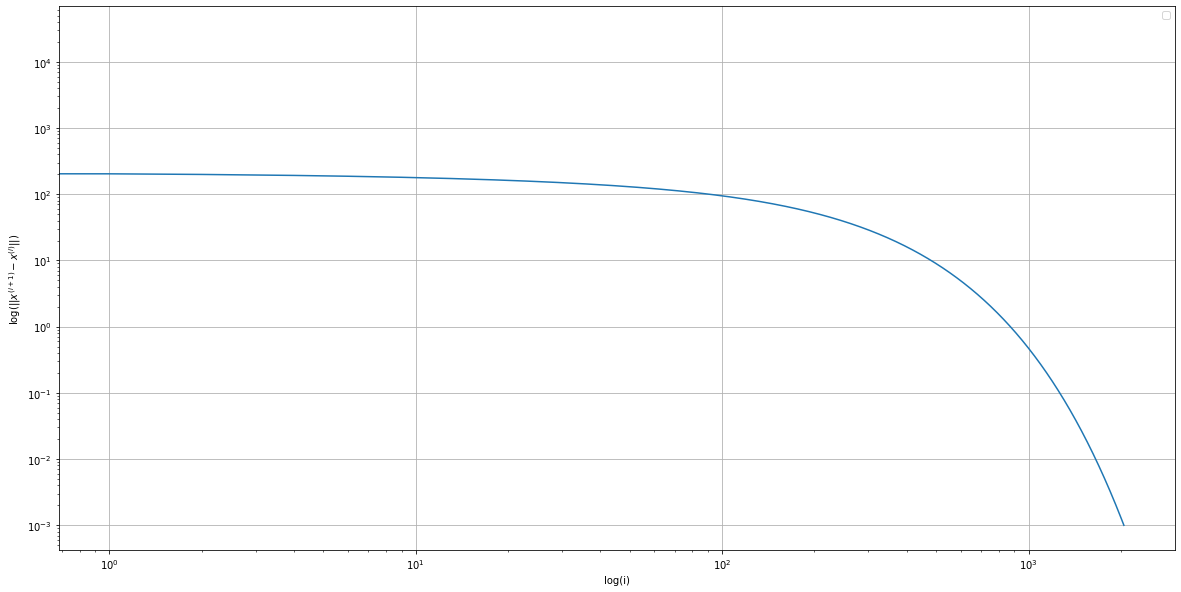

In [ ]:
print(iter)
print()
print(np.array(res).T)
pxi = np.zeros(n)
pxs = np.zeros(n)
for i in range(n):
  pxi[i] = res[i].lower
  pxs[i] = res[i].upper
plt.figure(figsize=(20,10))
plt.plot(pxi,label="inf")
plt.plot(pxs,label="sup")
plt.legend()
plt.grid()
plt.show()
xi = np.zeros((len(worklist), n))
xs = np.zeros((len(worklist), n))
plt.figure(figsize=(20,10))
for i in range(len(worklist)):
  z = worklist[i]
  for j in range(n):
    xi[i][j] = z[j].lower
    xs[i][j] = z[j].upper
norms = [np.linalg.norm(sti_vector(xi[i+1],xs[i+1]) - sti_vector(xi[i],xs[i]))for i in range(len(xi) - 1)]
  #norms = [np.linalg.norm(worklist[i + 1] - worklist[i]) for i in range(len(worklist) - 1)]
plt.plot(norms)
plt.xlabel('log(i)')
plt.ylabel(r"log($||x^{(i + 1)} - x^{(i)}||$)")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

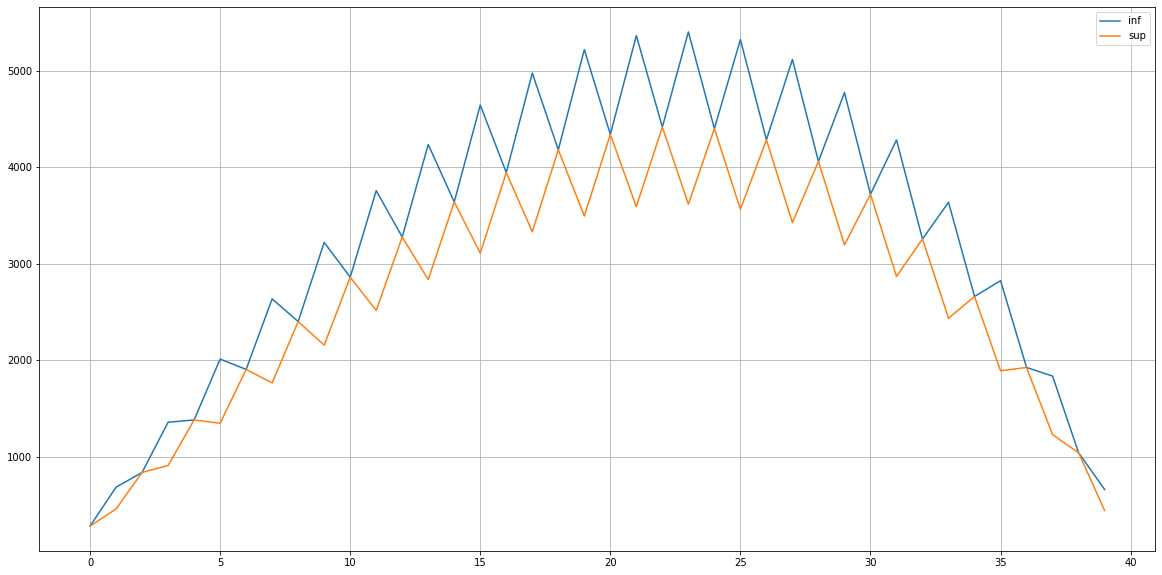

No handles with labels found to put in legend.


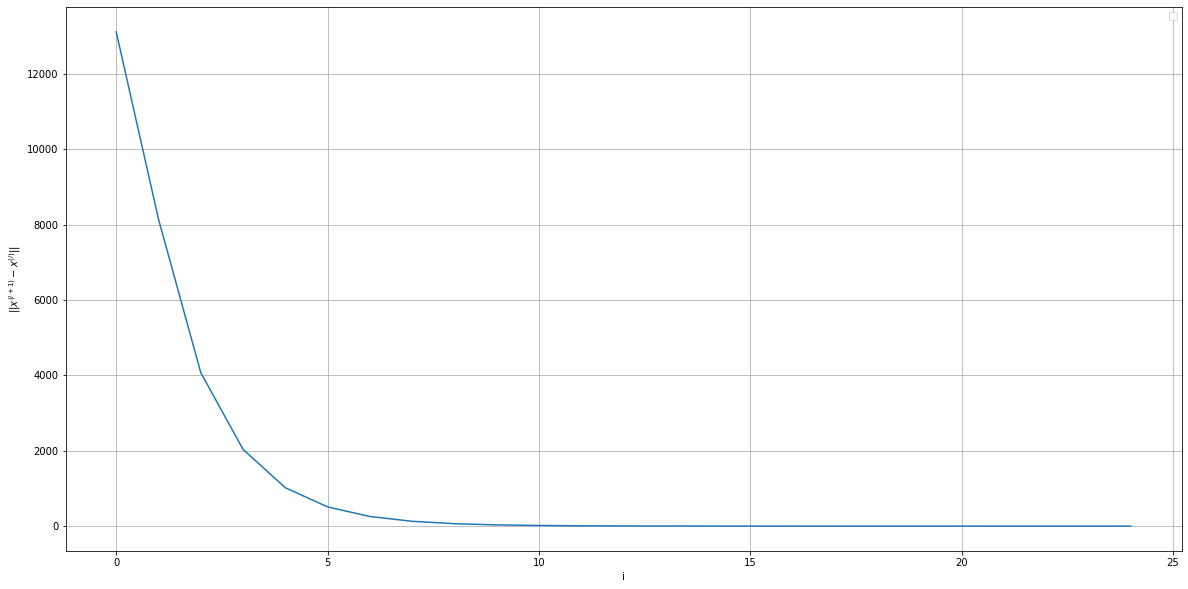

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(res2[0],label="inf")
plt.plot(res2[1],label="sup")
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(20,10))
norms = [np.linalg.norm(worklist2[i + 1] - worklist2[i]) for i in range(len(worklist2) - 1)]
plt.plot(norms)
plt.xlabel('i')
plt.ylabel(r"$||x^{(i + 1)} - x^{(i)}||$")
plt.legend()
plt.grid()
plt.show()